This example shows a comparison between the OptWRF ensemble (composed of the five top-perfoming OptWRF simuations) and the NCAR ensemble, which is composed of 4 members with NCAR-recommended physics parameterizations.

Last Updated by Jeffrey Sward on November 16, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
# import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def replace_large_w_nan(ds, keys, large_num=1 * 10 ** 23):
    for key in keys:
        ds[key].values[ds[key] > large_num] = np.nan
    return ds

## Read in data from a csv snapshot of the OptWRF database

In [3]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./db_snapshots/optwrf_database_FINAL_exp02.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data = replace_large_w_nan(data, ['fitness', 'ghi_error', 'wpd_error'])
# data['fitness'].values[data['fitness'] > 1 * 10 ** 23] = np.nan
# data['ghi_error'].values[data['ghi_error'] > 1 * 10 ** 23] = np.nan
# data['wpd_error'].values[data['wpd_error'] > 1 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.sort_values(by='fitness').iloc[:5,:]

# Drop the rows that were created by error. 
# I think this error arose during the time when I was forcing wrfout data processing,
# Therefore, some fitness values were calculated based upon incomple simulations --
# rather than the full 24h...
# I manually checked the REAL top 7 (top 5 distinct parameter combinations) that show up below. 
data_corr = data.drop([1383, 1394, 1400, 1320])
data_corr.sort_values(by='fitness').iloc[:10,:]

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
1823,2011-12-13,19,4,4,7,8,99,1,7858.155964,5905.98,9890490.0,00h 47m 53s,winter
1678,2011-01-14,19,4,4,7,8,99,1,7859.014414,7366.20,7469159.5,01h 26m 12s,winter
1546,2011-12-13,8,4,1,7,8,1,1,8206.917441,6285.07,10156387.0,01h 37m 22s,winter
1158,2011-12-02,13,4,4,7,8,99,1,8479.804871,6300.34,10608263.0,01h 19m 03s,winter
2285,2011-01-14,19,4,1,7,8,99,1,8487.973471,8308.79,7531930.0,00h 00m 00s,winter
2094,2011-12-02,19,4,4,7,8,99,1,8519.195161,6520.63,10369682.0,00h 42m 37s,winter
1893,2011-01-14,19,4,3,7,8,1,1,8601.927235,8344.39,7748128.5,00h 00m 00s,winter
1604,2011-12-01,8,4,1,7,8,1,1,8605.085565,5817.64,11613000.0,01h 11m 55s,winter
2222,2011-12-17,19,4,4,7,8,99,1,8634.652557,6224.43,11292114.0,00h 00m 00s,winter
1838,2011-12-17,8,4,1,7,8,99,1,8675.862289,6335.51,11226029.0,00h 54m 41s,winter


## Now Read in the data from the OptWRF and NCAR ensembles

In [4]:
# Read in the OptWRF #1 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ow1 = pd.read_csv('./all_2011_exp/19mp4lw4sw7lsm8pbl99cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ow1 = replace_large_w_nan(ow1, ['fitness', 'ghi_error', 'wpd_error'])
ow1['member'] = pd.Series(['OptWRF 1'] * len(ow1), index=ow1.index)

# Read in the OptWRF #2 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ow2 = pd.read_csv('./all_2011_exp/8mp4lw1sw7lsm8pbl1cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ow2 = replace_large_w_nan(ow2, ['fitness', 'ghi_error', 'wpd_error'])
ow2['member'] = pd.Series(['OptWRF 2'] * len(ow2), index=ow2.index)

# Read in the OptWRF #3 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ow3 = pd.read_csv('./all_2011_exp/13mp4lw4sw7lsm8pbl99cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ow3 = replace_large_w_nan(ow3, ['fitness', 'ghi_error', 'wpd_error'])
ow3['member'] = pd.Series(['OptWRF 3'] * len(ow3), index=ow3.index)

# Read in the OptWRF #4 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ow4 = pd.read_csv('./all_2011_exp/19mp4lw1sw7lsm8pbl99cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ow4 = replace_large_w_nan(ow4, ['fitness', 'ghi_error', 'wpd_error'])
ow4['member'] = pd.Series(['OptWRF 4'] * len(ow4), index=ow4.index)

# Read in the OptWRF #5 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ow5 = pd.read_csv('./all_2011_exp/19mp4lw3sw7lsm8pbl1cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ow5 = replace_large_w_nan(ow5, ['fitness', 'ghi_error', 'wpd_error'])
ow5['member'] = pd.Series(['OptWRF 5'] * len(ow5), index=ow5.index)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [5]:
# Read in the NCAR #1 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ncar1 = pd.read_csv('./all_2011_exp/8mp4lw4sw2lsm2pbl6cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ncar1 = replace_large_w_nan(ncar1, ['fitness', 'ghi_error', 'wpd_error'])
ncar1['member'] = pd.Series(['NCAR 1'] * len(ncar1), index=ncar1.index)

# Read in the NCAR #2 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ncar2 = pd.read_csv('./all_2011_exp/8mp4lw4sw2lsm1pbl3cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ncar2 = replace_large_w_nan(ncar2, ['fitness', 'ghi_error', 'wpd_error'])
ncar2['member'] = pd.Series(['NCAR 2'] * len(ncar2), index=ncar2.index)

# Read in the NCAR #3 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ncar3 = pd.read_csv('./all_2011_exp/4mp4lw2sw2lsm2pbl1cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ncar3 = replace_large_w_nan(ncar3, ['fitness', 'ghi_error', 'wpd_error'])
ncar3['member'] = pd.Series(['NCAR 3'] * len(ncar3), index=ncar3.index)

# Read in the NCAR #4 csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
ncar4 = pd.read_csv('./all_2011_exp/6mp3lw3sw1lsm1pbl1cu_2011_database.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
ncar4 = replace_large_w_nan(ncar4, ['fitness', 'ghi_error', 'wpd_error'])
ncar4['member'] = pd.Series(['NCAR 4'] * len(ncar4), index=ncar4.index)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [6]:
ensembles = pd.concat([ow1, ow2, ow3, ow4, ow5, ncar1, ncar2, ncar3, ncar4], ignore_index=True, sort=False)
ensembles

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,member
0,2011-01-01,19,4,4,7,8,99,1,16536.624629,5667.40,30813626.0,01h 44m 49s,OptWRF 1
1,2011-01-02,19,4,4,7,8,99,1,15095.888726,6136.15,26693558.0,01h 43m 47s,OptWRF 1
2,2011-01-03,19,4,4,7,8,99,1,12392.743316,6177.42,20212358.0,05h 03m 59s,OptWRF 1
3,2011-01-04,19,4,4,7,8,99,1,9836.836046,6442.09,13747084.0,02h 30m 07s,OptWRF 1
4,2011-01-05,19,4,4,7,8,99,1,11061.815266,6377.84,16732159.0,02h 19m 56s,OptWRF 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,2011-12-27,6,3,3,2,1,1,1,29983.508654,6680.28,61235628.0,01h 23m 28s,NCAR 4
3281,2011-12-28,6,3,3,2,1,1,1,35945.255555,7129.34,74700752.0,02h 42m 26s,NCAR 4
3282,2011-12-29,6,3,3,2,1,1,1,21087.320592,5982.71,41162644.0,02h 55m 20s,NCAR 4
3283,2011-12-30,6,3,3,2,1,1,1,19247.934997,6291.27,36339268.0,01h 29m 22s,NCAR 4


In [7]:
# Create a DataFrame from all the members' data
frame = {'start_date':ow1.start_date,
         'OptWRF 1': ow1.fitness.values, 
         'OptWRF 2': ow2.fitness.values,
         'OptWRF 3': ow3.fitness.values,
         'OptWRF 4': ow4.fitness.values,
         'OptWRF 5': ow5.fitness.values,
         'NCAR 1': ncar1.fitness.values,
         'NCAR 2': ncar2.fitness.values,
         'NCAR 3': ncar3.fitness.values,
         'NCAR 4': ncar4.fitness.values,
        }
ensemble_fitness =  pd.DataFrame(frame)

# Group data by month, and take the mean 
e_fitness_monthly = ensemble_fitness.groupby(ensemble_fitness.start_date.dt.to_period("M")).mean()
e_fitness_monthly

,OptWRF 1,OptWRF 2,OptWRF 3,OptWRF 4,OptWRF 5,NCAR 1,NCAR 2,NCAR 3,NCAR 4
start_date,,,,,,,,,
2011-01,13091.417645,13161.285333,13095.524018,14055.542369,13247.956588,18820.753295,20044.982201,19977.825320,20251.325702
2011-02,18814.292042,19050.727073,18474.704233,20020.209976,18854.450366,30104.130366,32514.228201,30656.665960,32806.282898
2011-03,19342.459889,19506.646599,19081.518322,20557.173795,19585.729107,28797.826437,30818.635548,30163.743579,31384.691368
2011-04,26782.891918,27341.467164,26164.810755,28136.009782,27529.704910,35623.241575,38206.496362,38065.361662,38854.863690
2011-05,24644.674045,25713.279688,24373.910097,25719.071072,25795.544380,30102.517082,30970.458534,33845.229073,32458.396356
2011-06,24142.611887,25995.730838,24687.508483,25345.632335,26020.412160,28255.278468,29157.815029,32639.622211,31459.025701
2011-07,22171.737015,23850.259830,22913.675368,23784.158511,23949.358621,25177.470750,25604.894759,29142.095984,28730.093606
2011-08,21996.390173,23062.544680,22270.959978,23273.218997,23364.449744,26094.220254,25769.845812,28535.636227,28181.391599
2011-09,17677.547678,18429.368170,17381.892842,18687.223650,18600.322880,21241.770626,21668.180496,23651.399872,23213.631437


In [8]:
# Create a DataFrame from all the members' data
frame = {'start_date':ow1.start_date,
         'OptWRF 1': ow1.ghi_error.values, 
         'OptWRF 2': ow2.ghi_error.values,
         'OptWRF 3': ow3.ghi_error.values,
         'OptWRF 4': ow4.ghi_error.values,
         'OptWRF 5': ow5.ghi_error.values,
         'NCAR 1': ncar1.ghi_error.values,
         'NCAR 2': ncar2.ghi_error.values,
         'NCAR 3': ncar3.ghi_error.values,
         'NCAR 4': ncar4.ghi_error.values,
        }
ensemble_ghi_error =  pd.DataFrame(frame)

# Group data by month, and take the mean 
e_ghi_error_monthly = ensemble_ghi_error.groupby(ensemble_ghi_error.start_date.dt.to_period("M")).mean()
e_ghi_error_monthly

,OptWRF 1,OptWRF 2,OptWRF 3,OptWRF 4,OptWRF 5,NCAR 1,NCAR 2,NCAR 3,NCAR 4
start_date,,,,,,,,,
2011-01,6859.703226,7048.657419,7012.426129,8362.610968,7180.670000,7085.361935,7191.314194,8784.556452,7786.550333
2011-02,9013.575357,9402.806071,8586.346429,10786.716071,9077.838214,9142.191429,9256.485000,10710.548214,9604.722143
2011-03,11800.921613,12014.135161,11535.046452,13349.078065,12086.372581,11978.960968,12002.779677,14533.162000,12702.462258
2011-04,14578.570000,15017.297333,13891.470667,16201.451667,15192.039333,14988.272333,14999.937667,17616.396667,15343.871333
2011-05,17147.402581,18097.161290,16839.813548,18320.018710,18200.071935,17632.978065,17047.118387,21116.867419,17675.447419
2011-06,17155.152000,18880.974333,17706.122000,18389.900333,18908.340667,17615.878571,17421.788333,21600.358333,18590.235333
2011-07,17234.050333,18837.023226,18007.774194,18893.853548,18981.316452,17819.210000,17102.922000,20900.127742,18962.689355
2011-08,16045.130645,17172.838065,16298.894194,17448.534839,17502.237097,16130.622222,15761.185806,19182.203548,17251.039355
2011-09,13285.101000,14048.074667,12902.397000,14499.948667,14302.984333,13576.377586,13086.274000,16150.879000,14009.437000


In [9]:
# Create a DataFrame from all the members' data
frame = {'start_date':ow1.start_date,
         'OptWRF 1': ow1.wpd_error.values, 
         'OptWRF 2': ow2.wpd_error.values,
         'OptWRF 3': ow3.wpd_error.values,
         'OptWRF 4': ow4.wpd_error.values,
         'OptWRF 5': ow5.wpd_error.values,
         'NCAR 1': ncar1.wpd_error.values,
         'NCAR 2': ncar2.wpd_error.values,
         'NCAR 3': ncar3.wpd_error.values,
         'NCAR 4': ncar4.wpd_error.values,
        }
ensemble_wpd_error =  pd.DataFrame(frame)

# Group data by month, and take the mean 
e_wpd_error_monthly = ensemble_wpd_error.groupby(ensemble_wpd_error.start_date.dt.to_period("M")).mean()
e_wpd_error_monthly

,OptWRF 1,OptWRF 2,OptWRF 3,OptWRF 4,OptWRF 5,NCAR 1,NCAR 2,NCAR 3,NCAR 4
start_date,,,,,,,,,
2011-01,2.053604e+07,2.040997e+07,2.031020e+07,2.052152e+07,2.041400e+07,3.377455e+07,3.651237e+07,3.391223e+07,3.608036e+07
2011-02,2.938948e+07,2.930055e+07,2.931128e+07,2.926336e+07,2.937796e+07,5.594236e+07,6.146245e+07,5.460229e+07,6.156457e+07
2011-03,2.358179e+07,2.357132e+07,2.345799e+07,2.356048e+07,2.361906e+07,4.567440e+07,5.041632e+07,4.405592e+07,5.043170e+07
2011-04,3.298583e+07,3.338163e+07,3.294291e+07,3.281450e+07,3.345477e+07,5.307827e+07,5.918353e+07,5.333643e+07,5.998344e+07
2011-05,1.952142e+07,1.987262e+07,1.957698e+07,1.940054e+07,1.983867e+07,3.134408e+07,3.473269e+07,3.230234e+07,3.683440e+07
2011-06,1.671358e+07,1.702658e+07,1.670598e+07,1.664893e+07,1.702138e+07,2.541371e+07,2.797143e+07,2.635002e+07,3.066486e+07
2011-07,1.251596e+07,1.278710e+07,1.250119e+07,1.250570e+07,1.268800e+07,1.767831e+07,2.099941e+07,2.054189e+07,2.406946e+07
2011-08,1.725032e+07,1.732181e+07,1.735730e+07,1.722733e+07,1.732313e+07,2.740092e+07,2.682657e+07,2.592541e+07,2.929080e+07
2011-09,1.566463e+07,1.593930e+07,1.572815e+07,1.566113e+07,1.583949e+07,2.357797e+07,2.551290e+07,2.417626e+07,2.735393e+07


## Plots showing the perfomance of each ensemble member with respect to the origional OptWRF runs

In [10]:
# Sort optwrf data by start_date to make the plots look cleaner
data = data.sort_values(by='start_date')

In [11]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

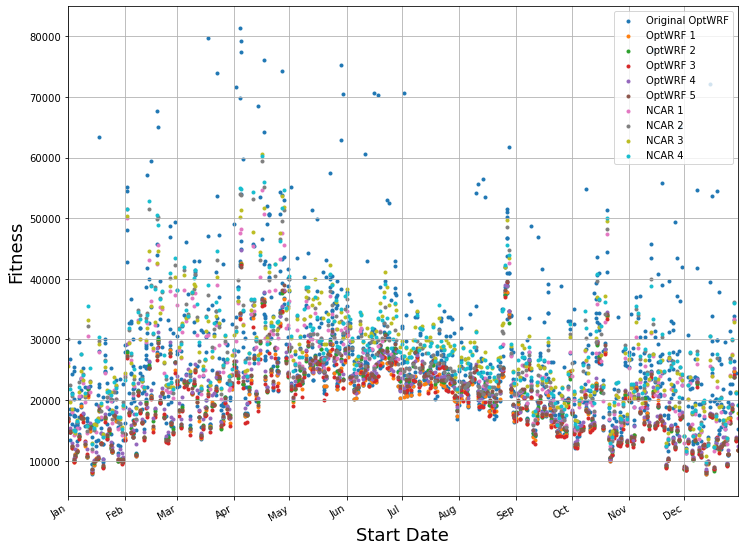

In [12]:
# Plot start_date vs fitness
fig, ax = plt.subplots(figsize=(12, 10))

# Original OptWRF data
plt.scatter(data_corr.start_date, data_corr.fitness, label='Original OptWRF', marker='.')

# Simulations from the top 5 perfoming OptWRF simulations
plt.scatter(ow1.start_date, ow1.fitness, label='OptWRF 1', marker='.')
plt.scatter(ow2.start_date, ow2.fitness, label='OptWRF 2', marker='.')
plt.scatter(ow3.start_date, ow3.fitness, label='OptWRF 3', marker='.')
plt.scatter(ow4.start_date, ow4.fitness, label='OptWRF 4', marker='.')
plt.scatter(ow5.start_date, ow5.fitness, label='OptWRF 5', marker='.')

# Simulations recommended by NCAR
plt.scatter(ncar1.start_date, ncar1.fitness, label='NCAR 1', marker='.')
plt.scatter(ncar2.start_date, ncar2.fitness, label='NCAR 2', marker='.')
plt.scatter(ncar3.start_date, ncar3.fitness, label='NCAR 3', marker='.')
plt.scatter(ncar4.start_date, ncar4.fitness, label='NCAR 4', marker='.')

# Format and save the plot
format_plot('Start Date', 'Fitness')
ax.legend()
# fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.pdf'
# plt.savefig(fig_path, transparent=True, bbox_inches='tight')

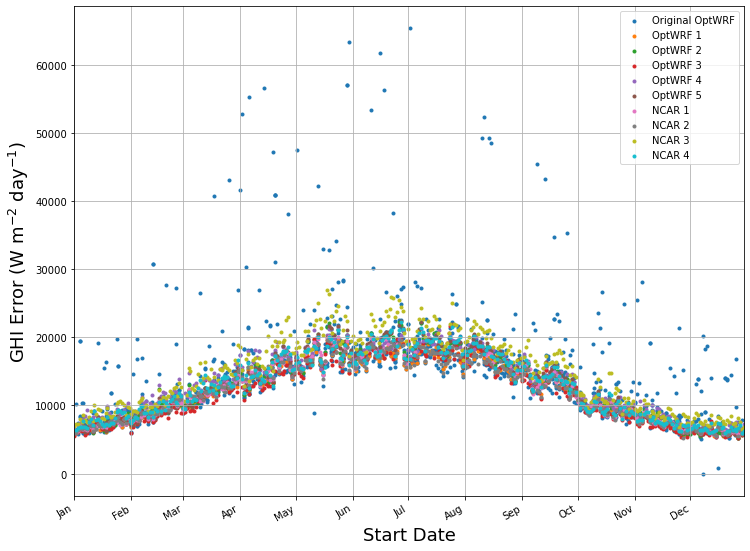

In [13]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))

# Original OptWRF data
plt.scatter(data_corr.start_date, data_corr.ghi_error, label='Original OptWRF', marker='.')

# Simulations from the top 5 perfoming OptWRF simulations
plt.scatter(ow1.start_date, ow1.ghi_error, label='OptWRF 1', marker='.')
plt.scatter(ow2.start_date, ow2.ghi_error, label='OptWRF 2', marker='.')
plt.scatter(ow3.start_date, ow3.ghi_error, label='OptWRF 3', marker='.')
plt.scatter(ow4.start_date, ow4.ghi_error, label='OptWRF 4', marker='.')
plt.scatter(ow5.start_date, ow5.ghi_error, label='OptWRF 5', marker='.')

# Simulations recommended by NCAR
plt.scatter(ncar1.start_date, ncar1.ghi_error, label='NCAR 1', marker='.')
plt.scatter(ncar2.start_date, ncar2.ghi_error, label='NCAR 2', marker='.')
plt.scatter(ncar3.start_date, ncar3.ghi_error, label='NCAR 3', marker='.')
plt.scatter(ncar4.start_date, ncar4.ghi_error, label='NCAR 4', marker='.')

# Format and save the plot
format_plot('Start Date', 'GHI Error (W m$^{-2}$ day$^{-1}$)')
ax.legend()

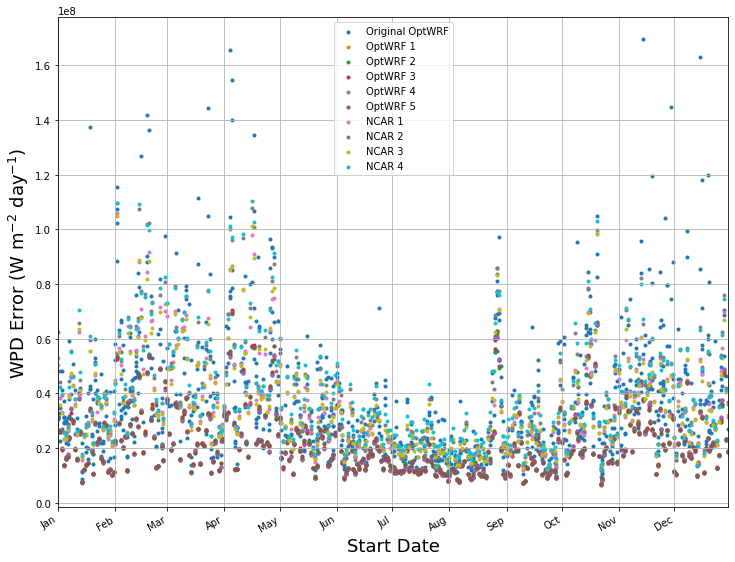

In [14]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))

# Original OptWRF data
plt.scatter(data_corr.start_date, data_corr.wpd_error, label='Original OptWRF', marker='.')

# Simulations from the top 5 perfoming OptWRF simulations
plt.scatter(ow1.start_date, ow1.wpd_error, label='OptWRF 1', marker='.')
plt.scatter(ow2.start_date, ow2.wpd_error, label='OptWRF 2', marker='.')
plt.scatter(ow3.start_date, ow3.wpd_error, label='OptWRF 3', marker='.')
plt.scatter(ow4.start_date, ow4.wpd_error, label='OptWRF 4', marker='.')
plt.scatter(ow5.start_date, ow5.wpd_error, label='OptWRF 5', marker='.')

# Simulations recommended by NCAR
plt.scatter(ncar1.start_date, ncar1.wpd_error, label='NCAR 1', marker='.')
plt.scatter(ncar2.start_date, ncar2.wpd_error, label='NCAR 2', marker='.')
plt.scatter(ncar3.start_date, ncar3.wpd_error, label='NCAR 3', marker='.')
plt.scatter(ncar4.start_date, ncar4.wpd_error, label='NCAR 4', marker='.')

# Format and save the plot
format_plot('Start Date', 'WPD Error (W m$^{-2}$ day$^{-1}$)')
ax.legend()

In [15]:
e_fitness_monthly.index = e_fitness_monthly.index.to_timestamp()

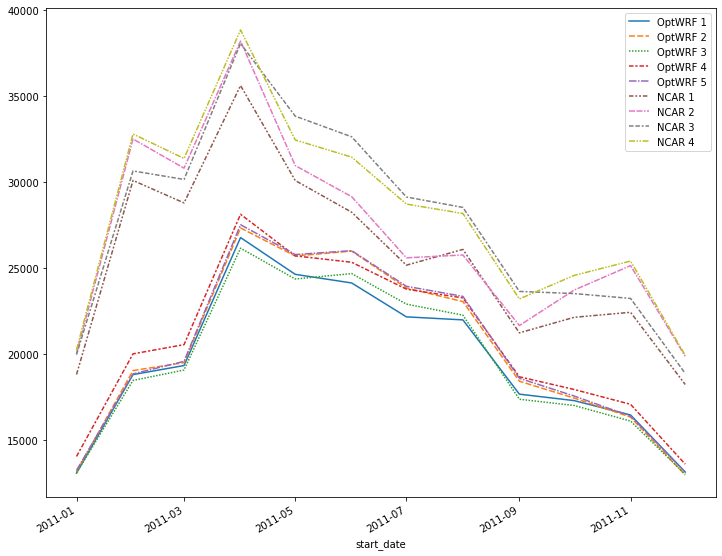

In [20]:
# Plot start_date vs fitness
fig, ax = plt.subplots(figsize=(12, 10))
# https://seaborn.pydata.org/examples/wide_data_lineplot.html
# Original OptWRF data
# plt.scatter(data_corr.start_date, data_corr.fitness, label='Original OptWRF', marker='.')
g = sns.lineplot(data=e_fitness_monthly)

fig.autofmt_xdate()

In [47]:
ensembles_monthly = ensembles.groupby([ensembles.start_date.dt.month, ensembles.member]).mean()
ensembles_monthly

mp_physics  ra_lw_physics  ra_sw_physics  \
start_date member                                               
1          NCAR 1             8              4              4   
           NCAR 2             8              4              4   
           NCAR 3             4              4              2   
           NCAR 4             6              3              3   
           OptWRF 1          19              4              4   
...                         ...            ...            ...   
12         OptWRF 1          19              4              4   
           OptWRF 2           8              4              1   
           OptWRF 3          13              4              4   
           OptWRF 4          19              4              1   
           OptWRF 5          19              4              3   

                     sf_surface_physics  bl_pbl_physics  cu_physics  \
start_date member                                                     
1          NCAR 1                     2               2           6   
           NCAR 2                     2               1           3   
           NCAR 3                     2               2           1   
           NCAR 4                     2               1           1   
           OptWRF 1                   7               8          99   
...                                 ...             ...         ...   
12         OptWRF 1                   7               8          99   
           OptWRF 2                   7               8           1   
           OptWRF 3                   7               8          99   
           OptWRF 4                   7               8          99   
           OptWRF 5                   7               8           1   

                     sf_sfclay_physics       fitness    ghi_error  \
start_date member                                                   
1          NCAR 1                    2  18820.753295  7085.361935   
           NCAR 2                    1  20044.982201  7191.314194   
           NCAR 3                    2  19977.825320  8784.556452   
           NCAR 4                    1  20251.325702  7786.550333   
           OptWRF 1                  1  13091.417645  6859.703226   
...                                ...           ...          ...   
12         OptWRF 1                  1  13146.500944  6040.415161   
           OptWRF 2                  1  12974.542613  6049.653226   
           OptWRF 3                  1  13012.920916  6057.964839   
           OptWRF 4                  1  13606.836689  6805.443226   
           OptWRF 5                  1  13147.831004  6260.460000   

                        wpd_error  
start_date member                  
1          NCAR 1    3.377455e+07  
           NCAR 2    3.651237e+07  
           NCAR 3    3.391223e+07  
           NCAR 4    3.608036e+07  
           OptWRF 1  2.053604e+07  
...                           ...  
12         OptWRF 1  2.221140e+07  
           OptWRF 2  2.179045e+07  
           OptWRF 3  2.186881e+07  
           OptWRF 4  2.217035e+07  
           OptWRF 5  2.188776e+07  

[108 rows x 10 columns]

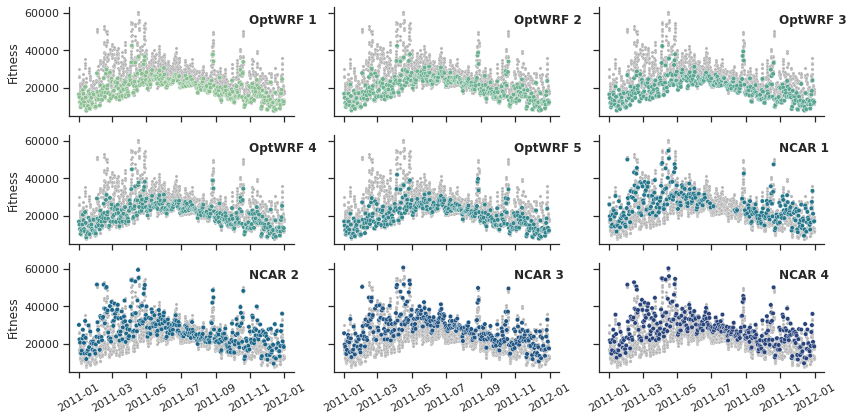

In [60]:
sns.set_style("ticks")
# Plot each year's time series in its own facet
g = sns.relplot(
    data=ensembles,
    x="start_date", y="fitness", col="member", hue="member",
    kind="scatter", palette="crest", zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False, s=20
)

# Iterate over each subplot to customize further
for member, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, member, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.scatterplot(
        data=ensembles, x="start_date", y="fitness",
        estimator=None, color=".7", ax=ax, s=10
    )

# Reduce the frequency of the x axis ticks
# ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_xticklabels(rotation=30)
g.set_titles("")
g.set_axis_labels("", "Fitness")
g.tight_layout()


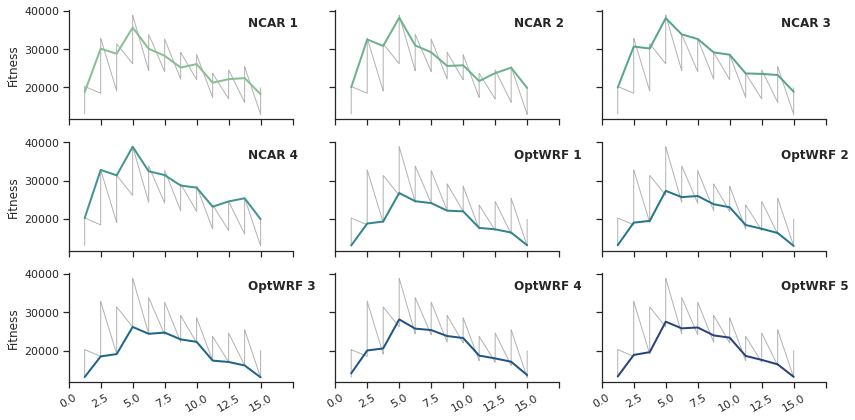

In [66]:
sns.set_style("ticks")
# Plot each year's time series in its own facet
g = sns.relplot(
    data=ensembles_monthly,
    x="start_date", y="fitness", col="member", hue="member",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False,
)

# Iterate over each subplot to customize further
for member, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, member, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=ensembles_monthly, x="start_date", y="fitness",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
# ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_xticklabels(rotation=30)
g.set_titles("")
g.set_axis_labels("", "Fitness")
g.tight_layout()


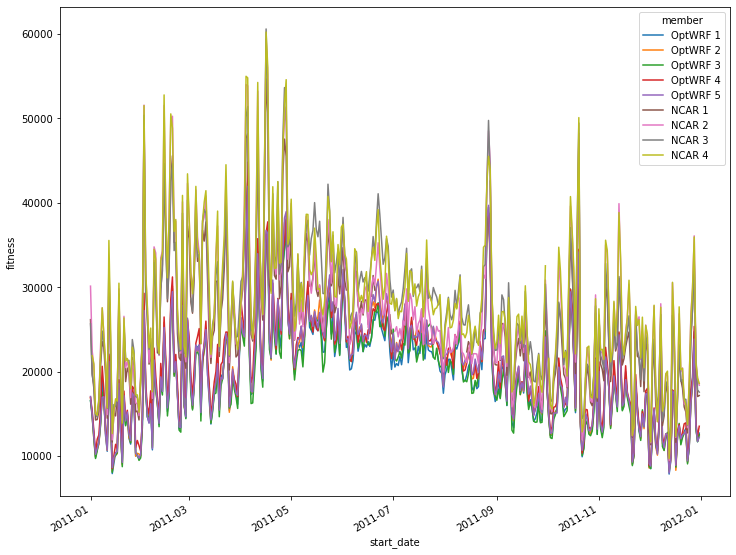

In [18]:
# Plot start_date vs fitness
fig, ax = plt.subplots(figsize=(12, 10))

g = sns.lineplot(x="start_date", y="fitness",
             hue="member", data=ensembles)
fig.autofmt_xdate()

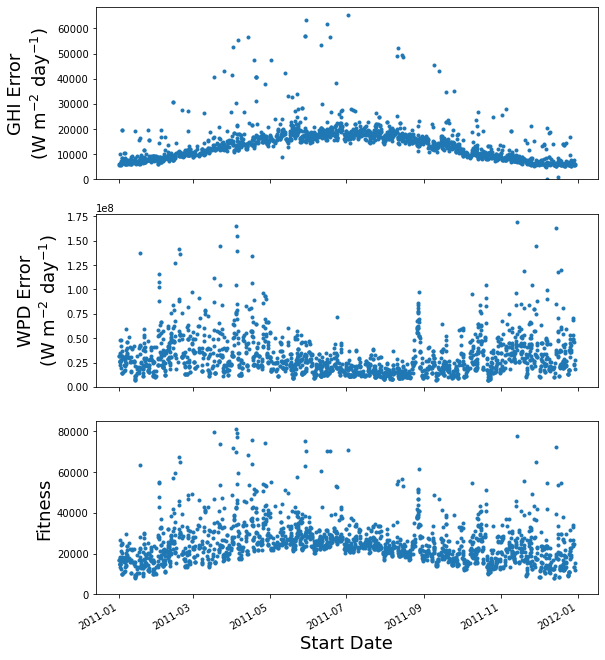

In [19]:
# Now, create the above three plots in the same frame
# Create a figure
fig = plt.figure(figsize=(9,12))

# Create the GHI error plot
ax_ghierr = fig.add_subplot(3,1,1)
plt.setp(ax_ghierr.get_xticklabels(), visible=False)  # make these tick labels invisible
ax_ghierr.scatter(data_corr.start_date, data_corr.ghi_error, marker='.')
format_plot('Start Date', 'GHI Error\n(W m$^{-2}$ day$^{-1}$)')
ax_ghierr.set_ylim(0)

# Create the WPD error plot
ax_wpderr = fig.add_subplot(3,1,2, sharex=ax_ghierr)
plt.setp(ax_wpderr.get_xticklabels(), visible=False)  # make these tick labels invisible
ax_wpderr.scatter(data_corr.start_date, data_corr.wpd_error, marker='.')
format_plot('Start Date', 'WPD Error\n(W m$^{-2}$ day$^{-1}$)')
ax_wpderr.set_ylim(0)

# Create the fitness plot
ax_fitness= fig.add_subplot(3,1,3, sharex=ax_wpderr)
ax_fitness.scatter(data_corr.start_date, data_corr.fitness, marker='.')
format_plot('Start Date', 'Fitness')
ax_fitness.set_ylim(0)

# fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/GHI_WPD_Err_Fitness_summary_plot'
fig_path = f'/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/figures/GHI_WPD_Err_Fitness_summary_plot'
# plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')
plt.show()